# A4: Visual Question Answering

In this assignment, you'll gain experience working with multi-input models. You'll develop a model that takes a question and an image as input, and returns a yes/no answer in response. You'll also gain experience working with larger datasets.

You are welcome to implement your model using either Model Subclassing or the Functional API. I suggest using the Functional API - it's worth gaining experience with, so you're familiar with it down the road. 

In either case, you will likely spend more time preparing and preprocessing the dataset, than you will developing your model.

## Your starter dataset

The [VQA dataset](https://visualqa.org/download.html) includes images and JSON containing the questions and answers. To save you time parsing the JSON (and various other preprocessing work), I've prepared a subset of the dataset in an easier to read CSV file. 

You should download your starter dataset from [here](https://storage.cloud.google.com/applied-dl/mini-vqa/starter.csv). 

Your starter CSV has three columns, giving the question, answer, and image.

question|answer|image
:-----:|:-----:|:-----:
is the sky blue|yes|COCO\_train2014\_000000393221.jpg
is there snow on the mountains|yes|COCO\_train2014\_000000393221.jpg
is the window open|no|COCO\_train2014\_000000393223.jpg

### Notes on how this was prepared.
* The starter dataset contains all the "yes" / "no" questions from the VQA v2 training annotations. 
* The answers are the most frequent one to the question (ties broken randomly). 
* The text has been cleaned (lowercased, punctuation removed). 
* Each image has at least two associated questions, some have more.
* There are 140,637 questions, and 42,985 images.
* The image filenames correspond to the [COCO 2014 training images](http://images.cocodataset.org/zips/train2014.zip). Note this file is about 11GB. You will need to download this later.

### A note on downloading the COCO training images

The training images are large, and you may not want to download them repeatedly in Colab (for example, if your instance disconnects). Continue reading the assignment below for tips before downloading them. 

In general, your workflow for this assignment will be to:

Part 1: 
- Write a separate notebook to download the training images. 
- Preprocess the images referenced in the starter dataset (e.g. by resizing them to 299x299). Disgard the other images. 
- Create a zip containing only the resized images from the starter dataset (it should be about 500MB) and upload that to web.
- To host a zip on the web, you can use either your Columbia account, or any Cloud provider (for example, [Cloud storage](https://cloud.google.com/storage/docs/creating-buckets)). Do not pay for a Cloud solution for this class (GCP, for example, has a free tier you can use).

Part 2:
- Write a separate notebook to train your model. At the start of this notebook, download your 500MB zip containing the preprocessed training images using a command like ```!wget``` or the code shown below.

### A note on creating and training your model

You can find an example VQA model at the bottom of this [guide](https://keras.io/getting-started/functional-api-guide/). Note: you should start with a smaller model (in terms of vocabulary size,sequence length, and other parameters). 

Other changes: 
* Instead of training a CNN from scratch, you will use a pretrained model (Inception-V3) and cache activations to disk. 
* Your model will take a while to train. It is important that you save a [checkpoint](https://www.tensorflow.org/guide/keras/save_and_serialize) to disk after each epoch (or every several epochs). Before training your model, check for existing checkpoints, and load the latest one.

Training tips:

* When developing a complex model, it is important to fit on a single batch first (repeatedly train on the same batch of 32 examples and labels). Verify your model can successfully memorize this data (the loss should go to zero). 

* Next, write code to make predictions on each of these images, and to display the image, question, and answer. Make sure the results are sensible. 

* As always, start with a simple model, get that working end-to-end, then gradually scale up.

* Code defensively and get to know your data. There will be several preprocessing steps (resizing images, caching actiations, tokenization, padding, etc). After each one, write a short block of code to verify the output is correct.

## Starter code

The starter code below contains various blocks you can use for your two notebooks (the first to download and preprocess the data, the second to train your model).

## Submission instructions

Please submit this assignment on CourseWorks by uploading one or more Jupyter notebooks that include saved output.

In [0]:
!pip install Pillow

In [0]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import shutil
import time
import csv
import IPython.display as display

from tqdm import tqdm
from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

## Notebook one: Download and preprocess the COCO training images
Create a new notebook for this part of the assignment.

In this section, you will download your starter CSV and the COCO training images. Preprocess the +/- 40,000 images from the starter CSV (by resizing them to 299x299 using Pillow), and create a zip file called "thumbnails.zip". Your zip should be around 500MB. 

Finally, upload your "thumbnails.zip" to the Cloud, so you can easily download it in your second notebook.

### Tips

I recommend downloading the COCO images with curl, so you can resume your download if it is [interrupted](https://stackoverflow.com/questions/19728930/how-to-resume-interrupted-download-automatically-in-curl) or stalls.

In Colab (or on Linux / Mac):

```
$ curl -L -O your_url
```

You can download these images in Colab, but you may need to be mindful of disk usage. As a tip to save disk space, after unzipping them, you may delete any images from the zip not referenced in the starter code.

After you've downloaded them with curl, here's a command  you can use to unzip them:

```
$ unzip -q from_zip -d to_folder
```

Also note: there are so many images that opening the folder in the Colab will be slow. Instead of opening the folder with the UI, you can use these shell commands to explore it:

```
$ ls -lha
$ du -sh
```

### Download the starter CSV

In [0]:
# Starter code to download small files
# Use this to download your starter CSV in notebook one and two.
# Also use it to download your thumbnails.zip in notebook two.
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

In [0]:
colab_root = "/content/"

In [0]:
csv_path = os.path.join(colab_root, "starter.csv")
download_if_missing("https://storage.googleapis.com/applied-dl/mini-vqa/starter.csv",
                     csv_path)

9084928/9078552 [==============================] - 0s 0us/step


'/content/starter.csv'

Tip. Here are a few shell commands you can use to quickly inspect the CSV and familiarize yourself with the format.

In [0]:
!head $csv_path -n3 # take a look at a few rows

is the sky blue,yes,COCO_train2014_000000393221.jpg
is there snow on the mountains,yes,COCO_train2014_000000393221.jpg
is the window open,yes,COCO_train2014_000000393223.jpg


In [0]:
!wc -l $csv_path

140637 /content/starter.csv


### Download the COCO training images with curl

In [0]:
# Your code here
# Download the training images with curl, and unzip them.
# If you're working in Colab, be mindful of disk usage.
! curl -L -O http://images.cocodataset.org/zips/train2014.zip

In [0]:
mkdir data_set

In [0]:
! unzip -q train2014.zip -d data_set/

### Get to know your data.
Write code to display a few images, questions, and answers.

In [0]:
# Your code here
# Next, familiarze yourself with the data. 
# Add code to display a few images from the training set using matplotlib,
# and their corresponding questions and answers from the starter CSV.
# Don't trust that your data is perfect (any bugs are unintentional 
# on my part, but there may well be some). The time you spend poking
# around with it is always a good investment.

Q: can i make a telephone call while sitting at this desk  | Ans: yes  | image: COCO_train2014_000000056828.jpg
Q: is the monitor turned on  | Ans: no  | image: COCO_train2014_000000056828.jpg


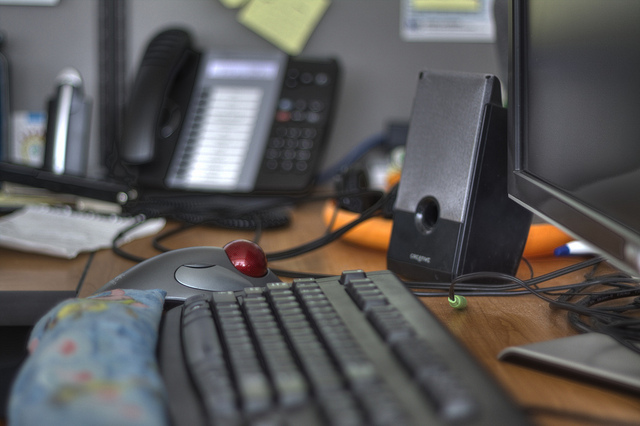

In [0]:
os.chdir(colab_root)
image_path = os.path.join(colab_root, "data_set/train2014")
all_images_path = os.listdir(image_path)
abs_image_path = []
for each in all_images_path:
 abs_image_path.append(os.path.join(image_path,each))

filename = "starter.csv"  
csvFile = open(filename, "r")
reader = csv.reader(csvFile)

rows = []
for item in reader:
    if reader.line_num == 1:
        continue
    rows.append(item)
csvFile.close()
rows = np.array(rows)
question, ans, image = rows[:,0] , rows[:,1] , rows[:,2]
j = random.randint(0,image.shape[0])
for n in range(image.shape[0]):
  if image[n] == image[j]:
    print("Q:",question[n]," | Ans:",ans[n]," | image:",image[n])
for i in range(len(all_images_path)):
  if all_images_path[i] == image[j]:
    display.display(display.Image(abs_image_path[i]))


### As a sanity check, verify you can locate all the images
Write code to verfy you can find every image mentioned in your starter CSV (in the unzipped COCO images).

In [0]:
# Your code here
# Next, write code to verfy you can find every image mentioned in the starter 
# CSV on disk. For example, you may want write a loop like this:
# import csv
# with open('starter.csv') as myfile:
#    reader = csv.reader(myfile, delimiter=',')
#    for row in reader:
#       question, answer, image = row
#       image = image.strip()
#       assert os.path.exists(os.path.join(coco_images_folder, image))


In [0]:
# Your code here
def sanitycheck(image_path):
  os.chdir(colab_root)
  with open('starter.csv') as myfile:
    reader = csv.reader(myfile, delimiter=',')
    for row in reader:
        question, answer, image = row
        image = image.strip()
        assert os.path.exists(os.path.join(image_path, image))
sanitycheck(image_path)

### Resize the images to 299x299
Next, resize the images referenced in starter CSV to 299x299 using Pillow.

### Tips
Here is code you can use to create a thumbnail of an image.

```
size = 299, 299
im = Image.open(path_to_image)
im.thumbnail(size)
out_file = os.path.join(your_directory, image_name)
im.save(out_file, "JPEG")
```

Note: do not change the image names when saving (your rezied image names should exactly match the names in the starter code).

In [0]:
# Your code here
# Resize all the images in the starter CSV to 299x299.
# Display a few and make sure the resize is working as expected.

In [0]:
new_dir = os.path.join(colab_root,"data_set")
for each in tqdm(image):
  #print(each)
  path_to_image = os.path.join(image_path,each)
  size = 299, 299
  im = Image.open(path_to_image)
  im.thumbnail(size)
  out_file = os.path.join(new_dir, each)
  im.save(out_file, "JPEG")


100%|██████████| 140636/140636 [18:38<00:00, 125.71it/s]


In [0]:
image_list = os.listdir(new_dir)
sized_path = []
for each in image_list:
  sized_path.append(os.path.join(new_dir,each))


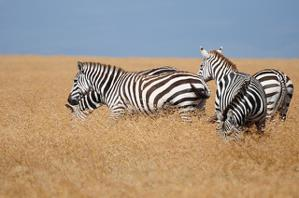

42985 is there snow on the mountains yes


In [0]:
display.display(display.Image(sized_path[0]))
print(len(sized_path),question[0],ans[0])

In [0]:
sanitycheck(new_dir)
print(new_dir)

/content/data_set


In [0]:
# Your code here
# Delete all images not mentioned in the starter CSV.
# As before (as a sanity check) make sure you can still locate every image 
# (now resized) mentioned in your starter CSV.
# Your code here
# Make sure your image folder contains only the images mentioned in your starter CSV.
for each in abs_image_path:
  if os.path.exists(each):
    os.remove(each)
  # else:
  #   print("The file does not exist")
if os.path.exists(image_path):
    os.rmdir(image_path)

In [0]:
sanitycheck(new_dir)

### Create a zip of your resized images

### Tips
Here is code you can use to zip a directory, creating a new zip file "thumbnails.zip"

```
shutil.make_archive('thumbnails', 'zip', [directory_to_zip])
```

In [0]:
# Your code here
# Create a thumbnails.zip
# Verify the size is around 500MB
shutil.make_archive('thumbnails', 'zip', new_dir)

'/content/thumbnails.zip'

### Upload your thumbnails.zip to the Cloud

You want to host your thumbnails.zip file at a URL, for example: ```https://storage.googleapis.com/[your_bucket_name]/thumbnails.zip```, so you can easily download it in your second notebook.

You can use either your Columbia account, or any Cloud provider.
Google Cloud [storage buckets](https://cloud.google.com/storage/docs/creating-buckets) are fine for this. You can use the [free tier](https://cloud.google.com/free/).

After this is done, you're ready to start on notebook two.

In [0]:
"https://storage.cloud.google.com/apl_hw4/thumbnails.zip?authuser=1&folder&organizationId"